In [1]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from pandarallel import pandarallel
import matplotlib.pyplot as plt
sys.path.append('../')
from utils import normalize_image, plot_image, plot_images

## Read and plot loss curves

### Functions

In [6]:
def parse_log_file(log_path):
    logs = {'epoch':[], 'loss':[], 'lr':[]}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.startswith('Epoch:'):
                continue
            tokens = line.split()
            epoch = tokens[1][1:].split('/')[0]
            # find index of 'loss:'
            if 'loss:' in tokens and 'lr:' in tokens:
                loss_i = tokens.index('loss:')
                loss = float(tokens[loss_i+1])
                lr_i = tokens.index('lr:')
                lr = float(tokens[lr_i+1])
                logs['epoch'].append(epoch)
                logs['loss'].append(loss)
                logs['lr'].append(lr)
    return logs

def parse_original_dino_log_file(log_path):
    logs = {'epoch':[], 'loss':[], 'lr':[]}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        print(f'read {len(lines)} lines')
        for line in lines:
            tokens = json.loads(line)
            logs['epoch'].append(tokens['epoch'])
            logs['loss'].append(tokens['train_loss'])
            logs['lr'].append(tokens['train_lr'])
    return logs

def parse_lightly_log_file(log_path):
    logs = {'epoch':[], 'loss':[], 'lr':[]}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        print(f'read {len(lines)} lines')
        for line in lines:
            if len(line) > 200:
                continue
            if line.startswith('{"train_loss'):
                tokens = line.split()
                epoch = tokens[3][:-1]
                loss = float(tokens[1][:-1])
                logs['epoch'].append(epoch)
                logs['loss'].append(loss)
            if line.startswith('{"lr-AdamW'):
                tokens = line.split()
                lr = float(tokens[1][:-1])
                logs['lr'].append(lr)
    return logs

def parse_dinov2_log_file(log_path):
    logs = {"iteration": [], "lr": [], "wd": [], "mom": [], "last_layer_lr": [], "total_loss": [], 
            "dino_local_crops_loss": [], "dino_global_crops_loss": [], "koleo_loss": [], "ibot_loss": []}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        print(f'read {len(lines)} lines')
        for line in lines:
            tokens = json.loads(line)
            for k in logs:
                logs[k].append(tokens[k])
    return logs

def plot_loss_n_lr_curve(logs, loss_key='loss', start=0):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle("Loss (left) and learning rate (right) curves")
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    step = list(range(len(logs[loss_key])))[start:]
    loss = logs[loss_key][start:]
    lr = logs['lr'][start:]
    ax1.scatter(step, loss, label=loss_key, color='blue')
    ax2.scatter(step, lr, label='lr', color='red')
    ax1.set_ylabel(loss_key)
    ax2.set_ylabel("Learning rate")
    ax1.legend(loc = 'upper left')
    ax2.legend(loc = 'upper right')
    plt.xlabel("Steps")
    plt.show()

### Supervised pretraining with NextViT code base

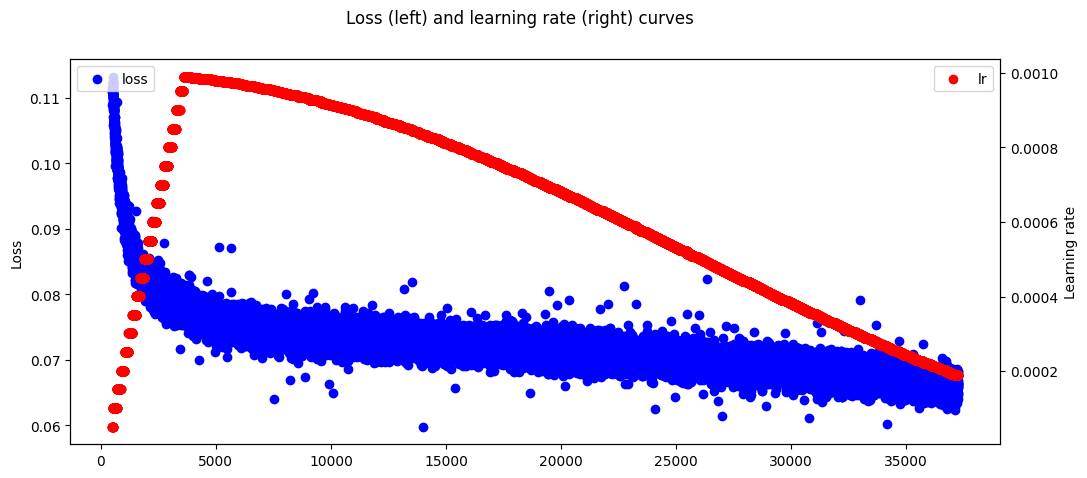

In [43]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/openimages_v7_0131/openimages_v7_0131.txt'
logs = parse_log_file(log_path)
plot_loss_n_lr_curve(logs, start=500)

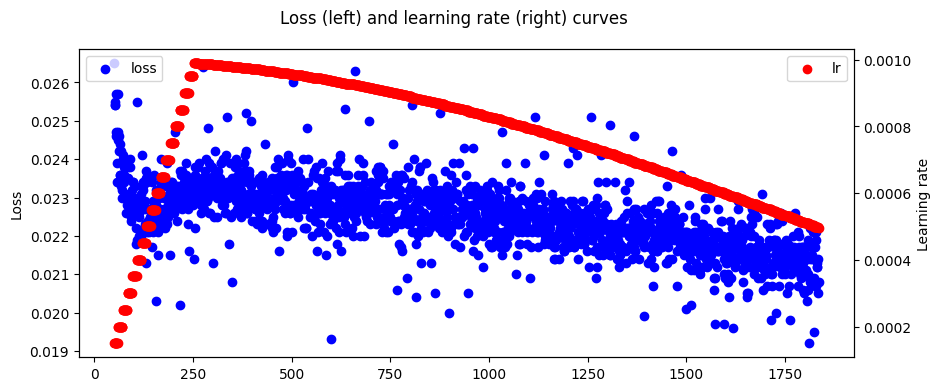

In [40]:
log_path = '/home/li.yu/code/scripts/coyo300m_nextvits_1030.txt'
logs = parse_log_file(log_path)
plot_loss_n_lr_curve(logs, start=50)

### Custom DINO pretraining

read 800 lines


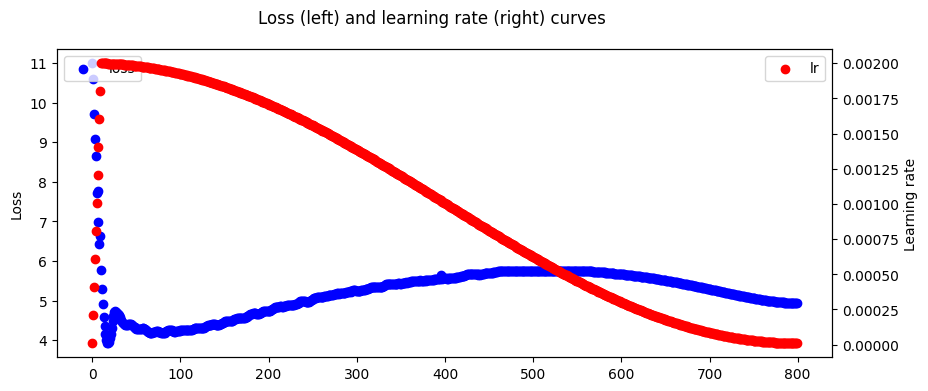

In [37]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dino_oi_coyo10m_1111/dino_deitsmall16_pretrain_log.txt'
logs = parse_original_dino_log_file(log_path)
plot_loss_n_lr_curve(logs, start=0)

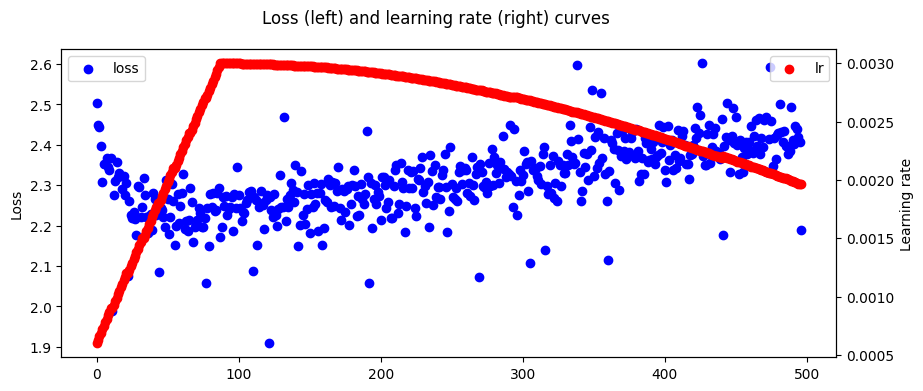

In [41]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dino_oi_coyo10m_1111/16305_0_log.out'
logs = parse_log_file(log_path)
plot_loss_n_lr_curve(logs, start=0)

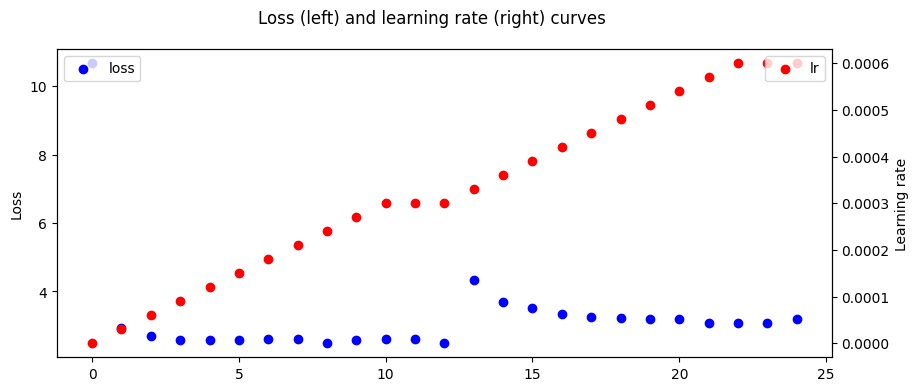

In [42]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dino_oi_coyo66m_1112/16415_0_log.out'
logs = parse_log_file(log_path)
plot_loss_n_lr_curve(logs, start=0)

### Lightly's DINO pretraining

read 105700 lines


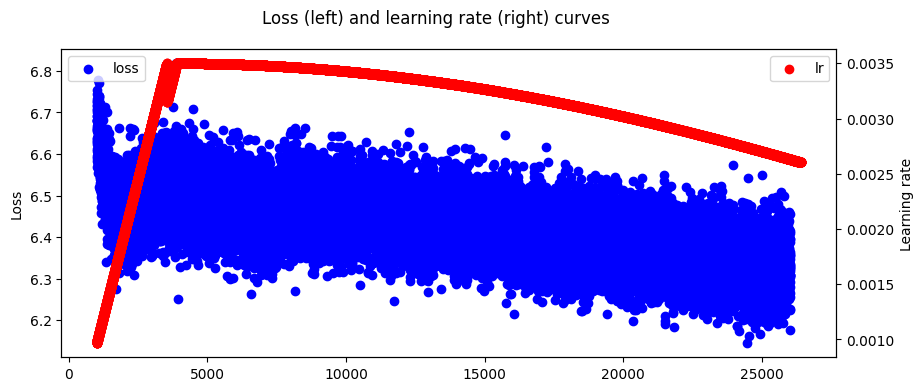

In [43]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/lightly_dino_pt0131_oi_coyo10m_rev2_5m_1010/metrics.jsonl'
logs = parse_lightly_log_file(log_path)
plot_loss_n_lr_curve(logs, start=1000)

### Custom DINOv2 pretraining

read 1716 lines
dict_keys(['iteration', 'lr', 'wd', 'mom', 'last_layer_lr', 'total_loss', 'dino_local_crops_loss', 'dino_global_crops_loss', 'koleo_loss', 'ibot_loss'])


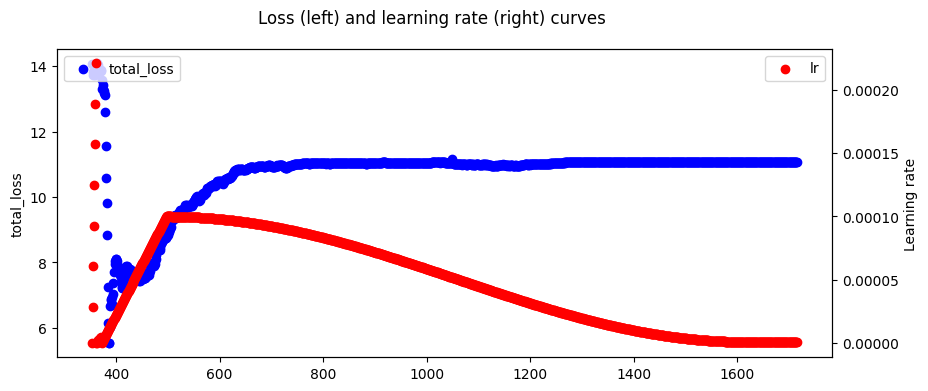

In [31]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dinov2_oi_1001/training_metrics.json'
logs = parse_dinov2_log_file(log_path)
print(logs.keys())
plot_loss_n_lr_curve(logs, loss_key='total_loss', start=354)

read 1518 lines


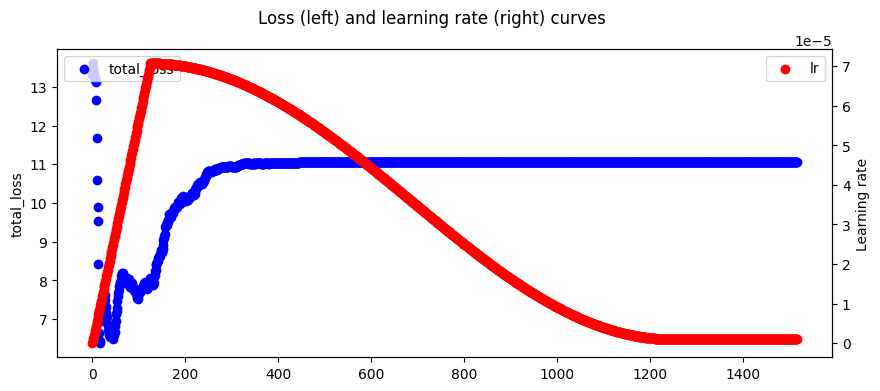

In [45]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dinov2_oi_1201/training_metrics.json'
logs = parse_dinov2_log_file(log_path)
plot_loss_n_lr_curve(logs, loss_key='total_loss', start=0)

read 364 lines


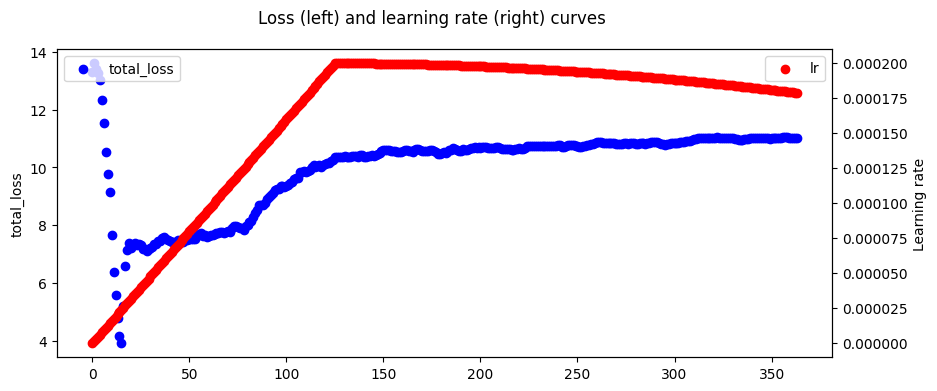

In [86]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dinov2_oi_step1250_1204/training_metrics.json'
logs = parse_dinov2_log_file(log_path)
plot_loss_n_lr_curve(logs, loss_key='total_loss', start=0)

read 4 lines


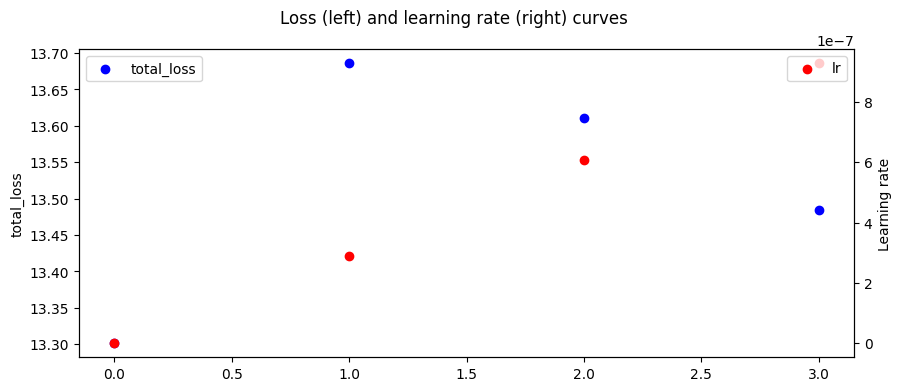

In [89]:
log_path = '/data/jupiter/li.yu/exps/driveable_terrain_model/dinov2_oi_step1250epoch5x_1205/training_metrics.json'
logs = parse_dinov2_log_file(log_path)
plot_loss_n_lr_curve(logs, loss_key='total_loss', start=0)

## Test custom dataset module

In [4]:
from PIL import Image
import torch
from torchvision import datasets, transforms

def pil_loader(p):
    return Image.open(p).convert("RGB")

class UnlabeledDatasetFolder(datasets.DatasetFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]  # Ignore the label
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data = datasets.DatasetFolder(data_dir, loader=pil_loader, extensions=["jpg"], transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index][0]

In [5]:
root_dir = '/data2/jupiter/datasets/public_datasets/small_ds'
dataset = CustomDataset(root_dir, transform=transforms.ToTensor())
len(dataset)

167056

In [7]:
img = dataset[0]
img.dtype, img.shape, img.min(), img.max()

(torch.float32, torch.Size([3, 768, 1024]), tensor(0.), tensor(1.))

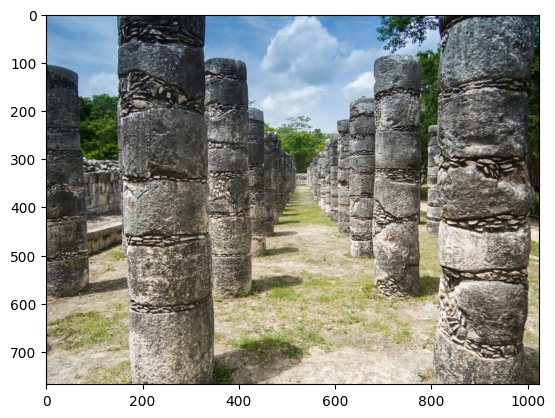

In [8]:
img_np = img.numpy().transpose((1, 2, 0))
plt.imshow(img_np)
plt.show()